<h2>Providing aid for backward countries</h2>

<h4>Problem Statement</h4>
<pre>
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid.
</pre>



<h4>Business Goal</h4>
<pre>
The job is to categorize the countries using some socio-economic and health factors that determine the overall development of the country. Then we need to suggest the countries which the CEO needs to focus on the most.
</pre>

In [1]:
#import libraries
import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [4]:
#load the data
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
print("Shape of the data:",df.shape)

Shape of the data: (167, 10)


<h4>Data Quality Check</h4>

In [6]:
#quality check of the data

#check for duplicate records in the data
if any(df.duplicated()):
    print("Duplicate records exist")
else:
    print("No duplicate records in the data")
    
#check for null values in the data
is_null = df.isna().sum()
print("\n")
print("Number of null values in the data:")
print(is_null)

No duplicate records in the data


Number of null values in the data:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


Observation: 
<pre>There are no duplicate records or null values in the data</pre>

<h4>Data Preparation</h4>

In [7]:
#convert exports,health and imports from percentages to values
df['exports'] = df['exports']*df['gdpp']*0.01
df['health'] = df['health']*df['gdpp']*0.01
df['imports'] = df['imports']*df['gdpp']*0.01

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


<h4>Outlier Detection</h4>

Text(0.5, 0.98, 'Outlier check on the data')

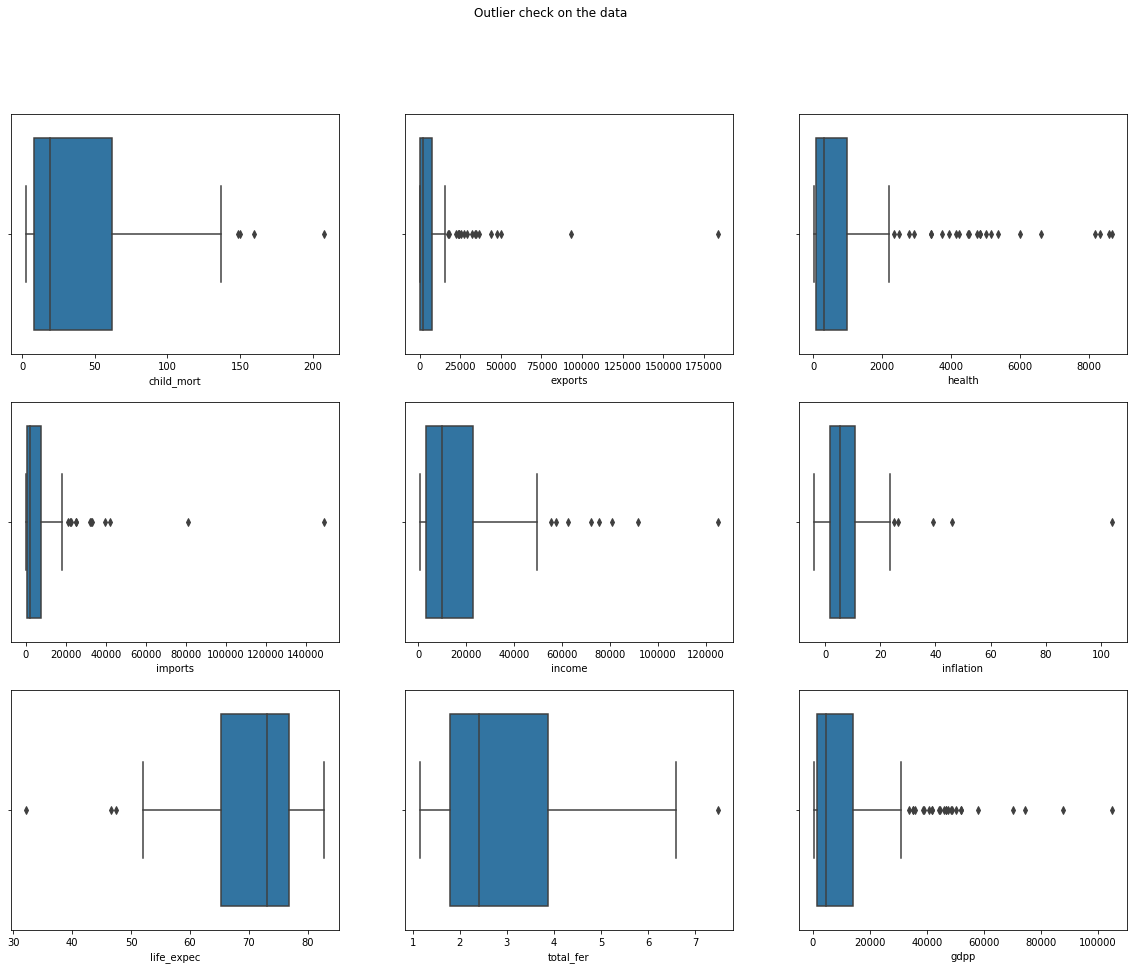

In [8]:
#remove outliers
plt.figure(figsize = (20,15))
features = df.columns[1:]
for i in enumerate(features):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(df[i[1]])
plt.suptitle("Outlier check on the data")

Observation:
<pre>
For backward countries child mortality can be high, life expectancy can be low so, we don't modify these values
It looks like there are ouliers present in exports, imports, income, inflation, total_fertility and gdp on the higher range of the values. 
So, we set all the values that are greater than 99th percentile value to the 99th percentile value</pre>

In [9]:
q_exports = df['exports'].quantile(0.99)
df['exports'][df['exports']>=q_exports] = q_exports

q_imports = df['imports'].quantile(0.99)
df['imports'][df['imports']>=q_imports] = q_imports

q_income = df['income'].quantile(0.99)
df['income'][df['income']>=q_income] = q_income

q_inflation = df['inflation'].quantile(0.99)
df['inflation'][df['inflation']>=q_inflation] = q_inflation

q_fer = df['total_fer'].quantile(0.99)
df['total_fer'][df['total_fer']>=q_fer] = q_fer

q_gdp = df['gdpp'].quantile(0.99)
df['gdpp'][df['gdpp']>=q_gdp] = q_gdp

<h4>Exploratory Data Analysis</h4>

Text(0.5, 0.98, 'Univariate analysis of the data')

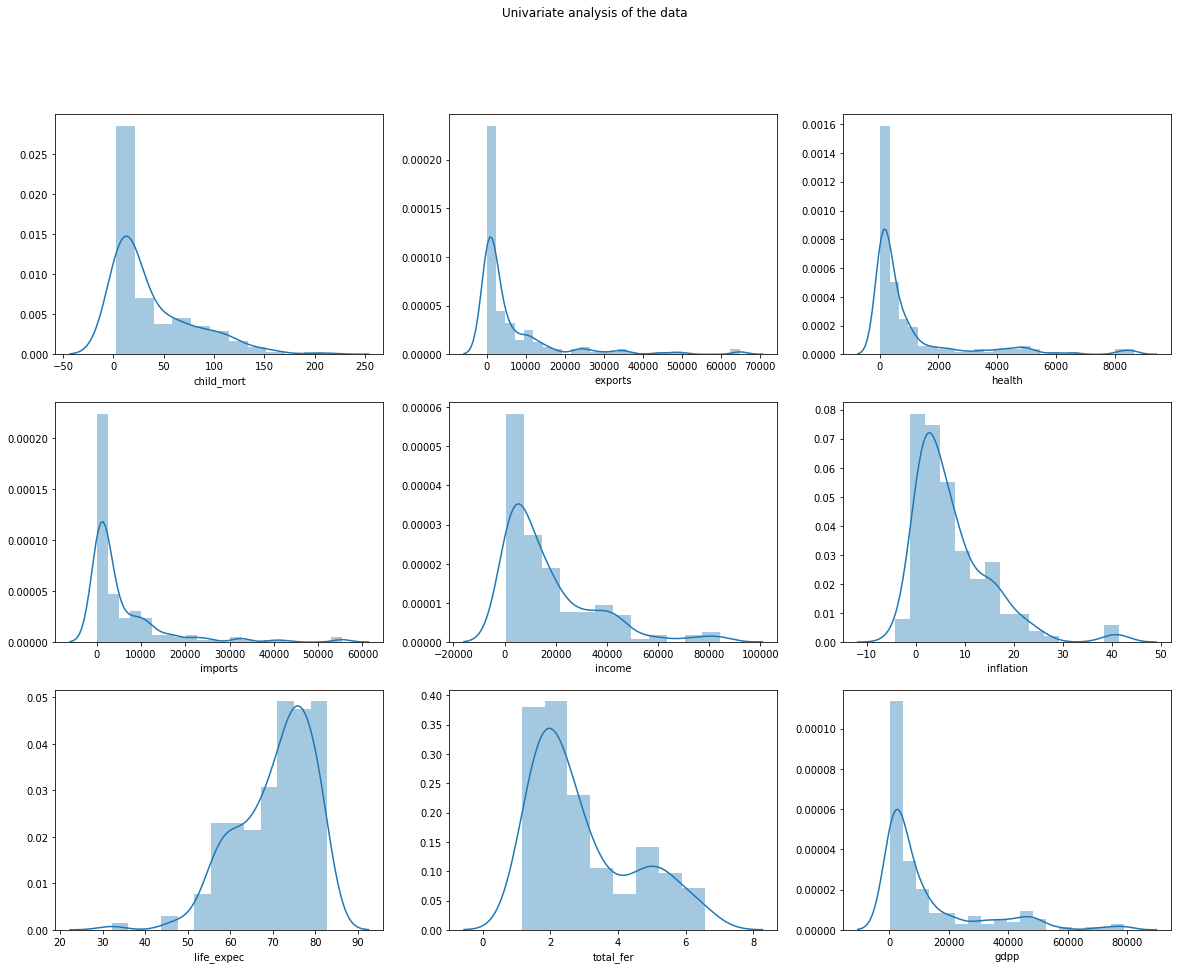

In [10]:
#Perform univariate analysis
plt.figure(figsize = (20,15))
features = df.columns[1:]
for i in enumerate(features):
    plt.subplot(3,3, i[0]+1)
    sns.distplot(df[i[1]])
plt.suptitle("Univariate analysis of the data")

Observation:
<pre>
We can see that the distribution of data for the features child mortality,income and gdp is not uniform, 
the data has values distributed from low range to high range, it implies that there are countries with good living standards and poor living standards. 
So we can use these features to form good clusters and find out backward countries.</pre>

<Figure size 432x288 with 0 Axes>

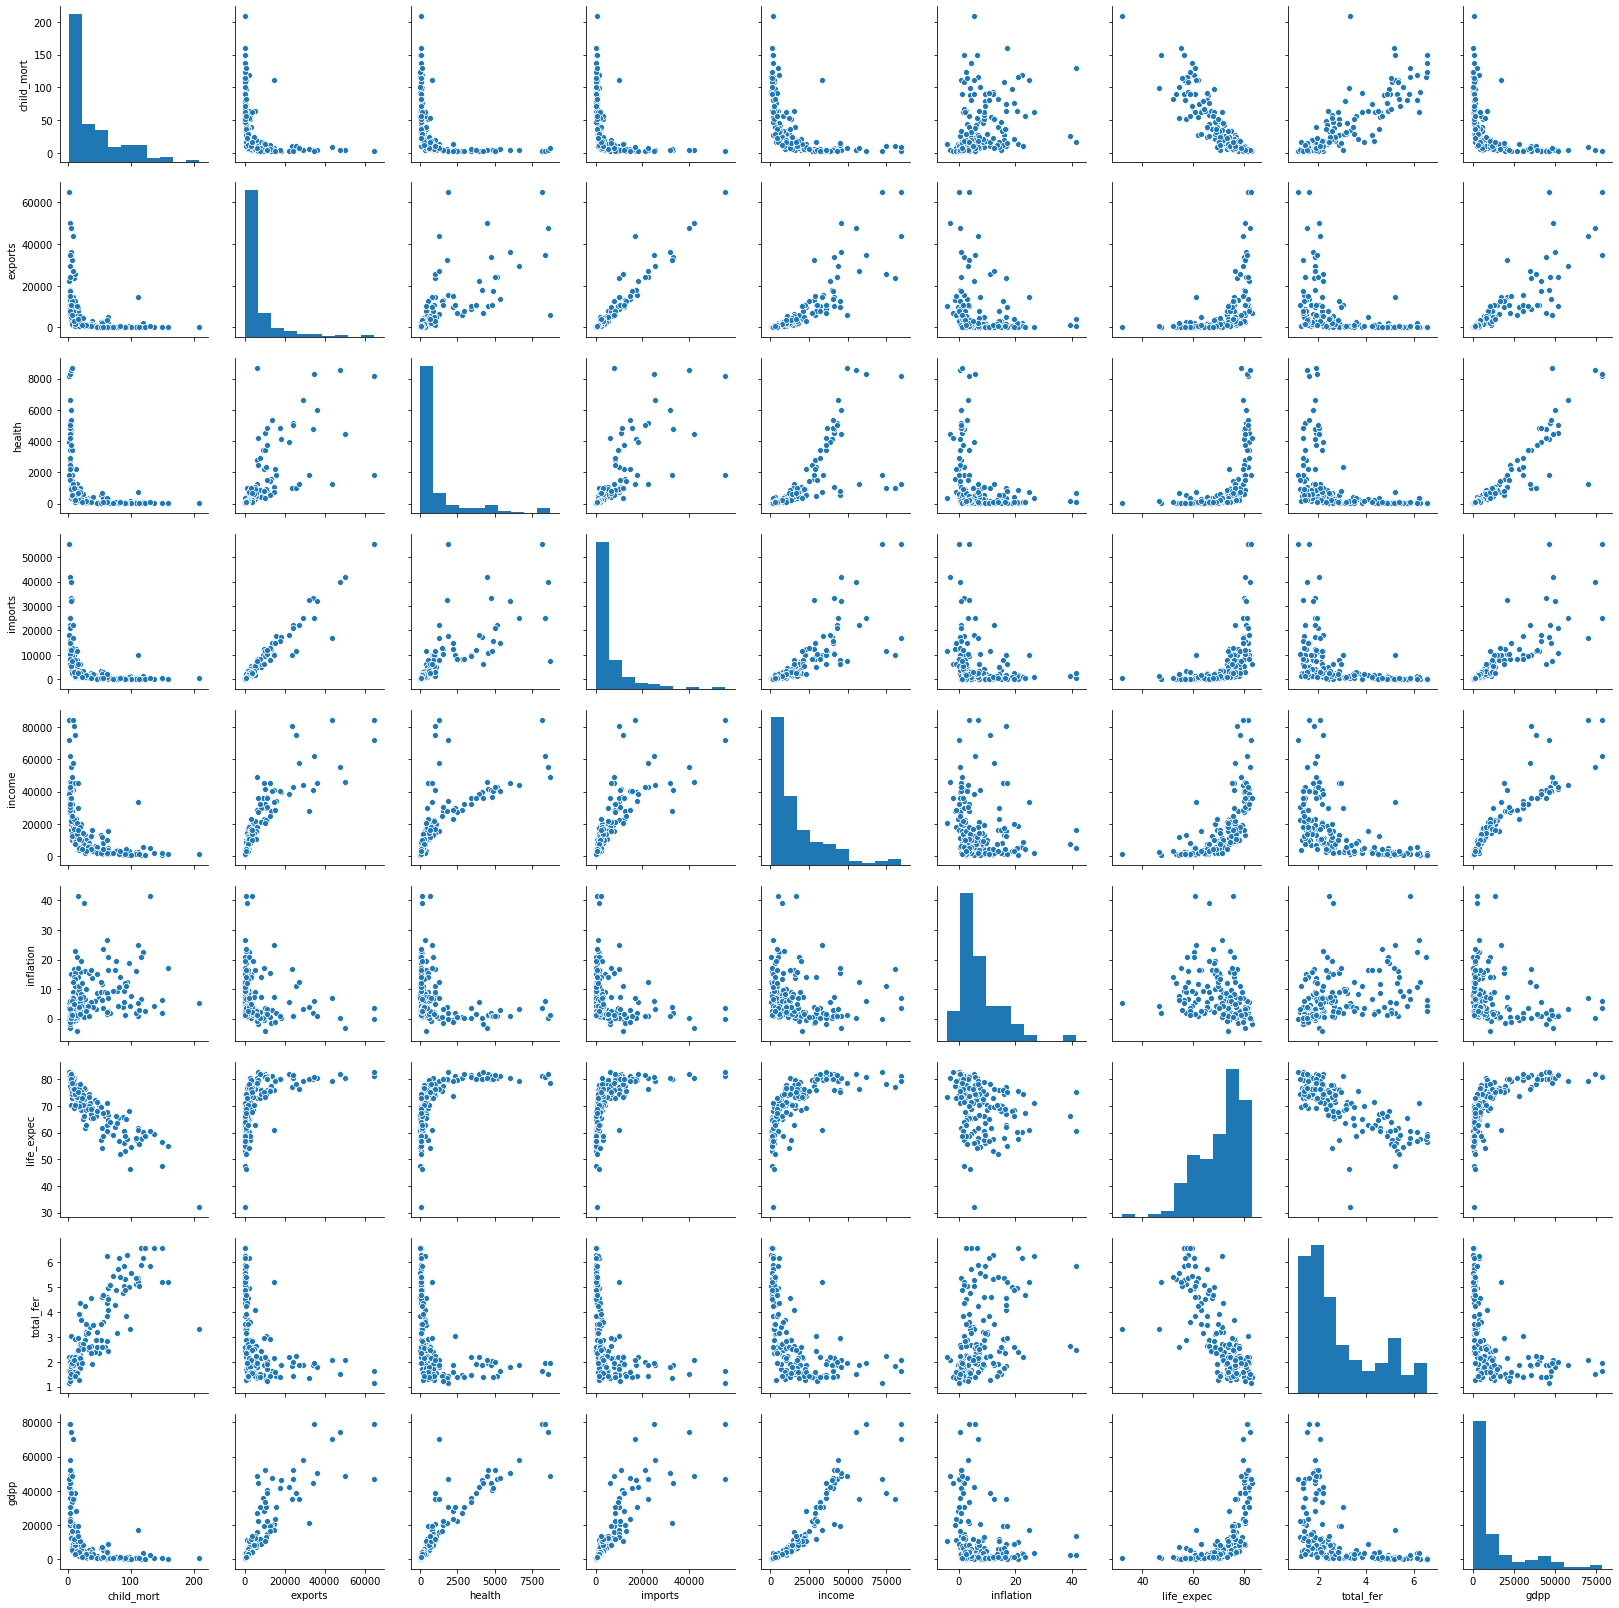

In [11]:
#bivariate analysis
plt.figure()
sns.pairplot(df)


Observation: 
<pre>
From the pairwise plot, we can see that there is no clear separation of data in any combination, 
so we can form clusters to separate backward countries assuming that there is noise in our data.
</pre>

<h3>Clustering</h3>

In [12]:
# Check the hopkins

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [13]:
print("Hopkin's score on the data:",hopkins(df.drop('country', axis = 1)))

Hopkin's score on the data: 0.9205419430021903


Observation: 
<pre>
We got a good hopkin's score(>0.8), so we can form good clusters
</pre>

<h4>Scaling</h4>

In [14]:
#scale the data so that the features with high values doesn't dominate the results
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df1 = scaler.fit_transform(df.drop('country', axis = 1)) #we drop text data to perform the analysis
df1

array([[ 1.29153238, -0.56962212, -0.56503989, ..., -1.61909203,
         1.92639646, -0.70225949],
       [-0.5389489 , -0.47385792, -0.43921769, ...,  0.64786643,
        -0.86505432, -0.49872564],
       [-0.27283273, -0.42399973, -0.48482608, ...,  0.67042323,
        -0.03498262, -0.47743428],
       ...,
       [-0.37231541, -0.49160668, -0.53848844, ...,  0.28695762,
        -0.66423052, -0.65869853],
       [ 0.44841668, -0.53995007, -0.55059641, ..., -0.34463279,
         1.15657191, -0.65869853],
       [ 1.11495062, -0.52701632, -0.54049845, ..., -2.09278484,
         1.64524315, -0.6500669 ]])

In [15]:
#convert the scaled data into a dataframe
df1 = pd.DataFrame(df1, columns = df.columns[1:]) 
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.565040,-0.598741,-0.851668,0.265002,-1.619092,1.926396,-0.702259
1,-0.538949,-0.473858,-0.439218,-0.413584,-0.386946,-0.372075,0.647866,-0.865054,-0.498726
2,-0.272833,-0.424000,-0.484826,-0.476100,-0.221053,1.122161,0.670423,-0.034983,-0.477434
3,2.007808,-0.381249,-0.532363,-0.463973,-0.612045,1.932987,-1.179234,2.153997,-0.530950
4,-0.695634,-0.086742,-0.178771,0.139728,0.125254,-0.764618,0.704258,-0.543736,-0.032042


<h3>KMeans Clustering</h3>

Text(0.5, 1.0, 'Silhouette Scores vs k')

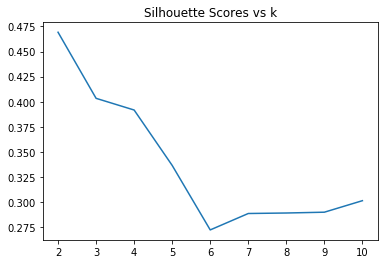

In [16]:
#perform kMeans clustering and plot silhouette scores to find the best k(number of clusters to form)
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])
plt.title("Silhouette Scores vs k")

Observation: 
<pre>
best cluster from the silhouette graph is k=3
</pre>

Text(0.5, 1.0, 'Cost vs k')

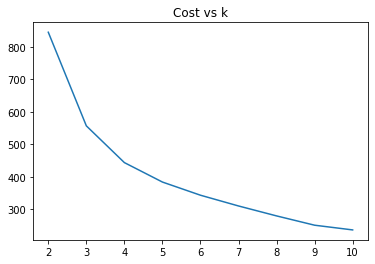

In [17]:
#perfrom KMeans and plot the costs to find the best k using elbow method
ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ssd.append([k, kmean.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])
plt.title("Cost vs k")

Observation:
<pre>
From the above graph, we have elbows at 3,4. So, we choose k=3 as it would be easy to interpret small number of clusters
</pre>

In [18]:
#build KMeans model with optimal numnber of clusters
kmean = KMeans(n_clusters = 3, random_state = 50)
kmean.fit(df1)

KMeans(n_clusters=3, random_state=50)

In [19]:
#make a copy of data
df_kmean = df.copy()

In [20]:
#convert labels data into a dataframe
label  = pd.DataFrame(kmean.labels_, columns= ['label'])
label.head()

,label
0,2
1,0
2,0
3,2
4,0


In [21]:
#concatenate label data with the copy of data(df_kmean)
df_kmean = pd.concat([df_kmean, label], axis =1)
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [22]:
#see how many data points belong to each cluster
df_kmean.label.value_counts()

0    90
2    48
1    29
Name: label, dtype: int64

<h4>Visualize the clusters</h4>

[Text(0.5, 1.0, 'Income vs Child mortality')]

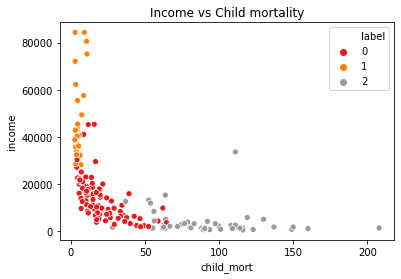

In [23]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'label', data = df_kmean, palette = 'Set1').set(title="Income vs Child mortality")

[Text(0.5, 1.0, 'gdpp vs child mortality')]

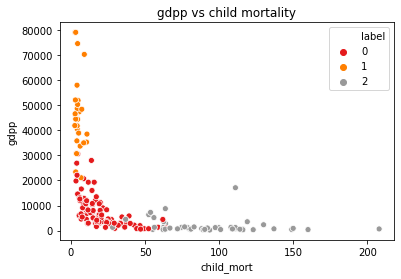

In [24]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'label', data = df_kmean, palette = 'Set1').set(title="gdpp vs child mortality")

[Text(0.5, 1.0, 'gdpp vs income')]

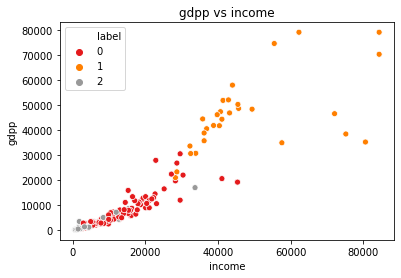

In [25]:
# Plot the cluster
sns.scatterplot(x = 'income', y = 'gdpp', hue = 'label', data = df_kmean, palette = 'Set1').set(title="gdpp vs income")

Observation: 
<pre>
From the above scatterplots, we can see that countries that belong to label=2 have low income, low gdp and high child mortality rate.
So, these countries need aid
</pre>

<h4>Cluster Profiling using KMeans</h4>

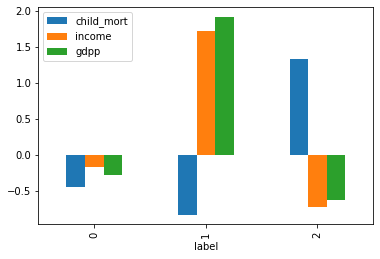

In [26]:
#scale df_kmean data since the columns are of different magnitudes. It makes our visualization easy
scaler = StandardScaler()
df_kmean_scaled = scaler.fit_transform(df_kmean[['child_mort','income','gdpp']])
df_kmean_scaled = pd.DataFrame(df_kmean_scaled,columns=['child_mort','income','gdpp'])
df_kmean_scaled = pd.concat([df_kmean_scaled,df_kmean['label']],axis=1)

df_kmean_scaled.groupby('label').mean().plot(kind = 'bar')

Observation:
<pre>
As mentioned above, cluster with label 2 has high child mortality rate, low income and low gdpp compared to other clusters. These countries need aid
</pre>

In [27]:
#find top 5 countries that need aid
df_kmean[df_kmean['label'] == 2].sort_values(by = ['gdpp','child_mort', 'income'], ascending = [True,False, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,2
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,2
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,2
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,2
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,2


Observation: 
<pre>
The results obtained from KMeans clustering suggest that these 5 countries should be given priority in providing aid:
1.Burundi 
2.Liberia
3.Congo,Dem. Rep.
4.Niger 
5.Sierra Leone
</pre>

<h3>Hierarchical Clustering</h3>

<h4>Single Linkage</h4>

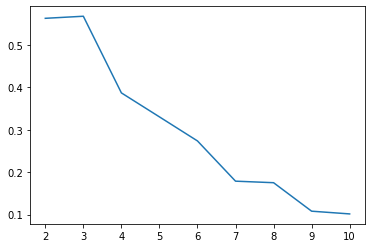

In [28]:
#perform hierarchical clustering using single linkage and plot silhouette scores to find best k
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    single = AgglomerativeClustering(n_clusters = k,linkage='single').fit(df1)
    ss.append([k, silhouette_score(df1, single.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])


<pre>
Observation: best k = 3
</pre>

In [34]:
#build single linkage model with optimal number of clusters
single = AgglomerativeClustering(n_clusters = 3,linkage='single')
single.fit(df1)

AgglomerativeClustering(linkage='single', n_clusters=3)

In [35]:
#make copy of our data
df_single = df.copy()

In [36]:
#convert the labels obtained from single linkage to dataframe
label  = pd.DataFrame(single.labels_, columns= ['label'])
label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [37]:
#concatenate labels with the df_single dataframe
df_single = pd.concat([df_single, label], axis =1)
df_single.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [38]:
#Check how many data points belong to each cluster
df_single.label.value_counts()

0    165
2      1
1      1
Name: label, dtype: int64

Observation: 
<pre>Single linkage model is not performing well, it is classifying most of the points into one cluster. Single linkage clustering model does not work well on noise data, so this behavior can be expected
</pre>

[Text(0.5, 1.0, 'income vs child mortality')]

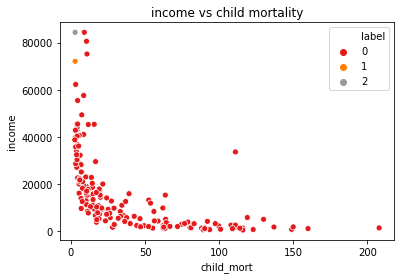

In [39]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'label', data = df_single, palette = 'Set1').set(title="income vs child mortality")

[Text(0.5, 1.0, 'gdpp vs child mortality')]

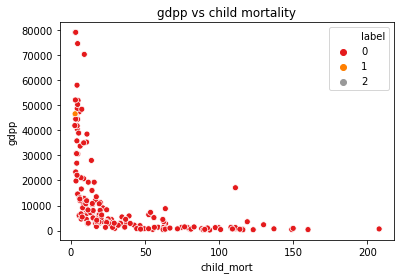

In [40]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'label', data = df_single, palette = 'Set1').set(title="gdpp vs child mortality")

[Text(0.5, 1.0, 'income vs gdpp')]

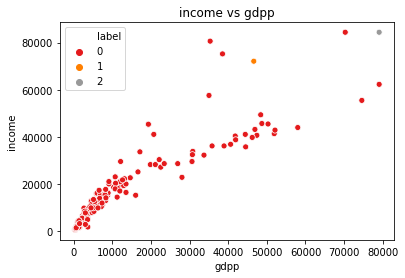

In [41]:
# Plot the cluster
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'label', data = df_single, palette = 'Set1').set(title="income vs gdpp")

Observation: 
<pre>
From the above three scatter plots, we can see that few countries which belong to label=0 have low income, low gdp and high child mortality rate. These countries should be given aid
</pre>

<h4>Cluster Profiling using single linkage model</h4>

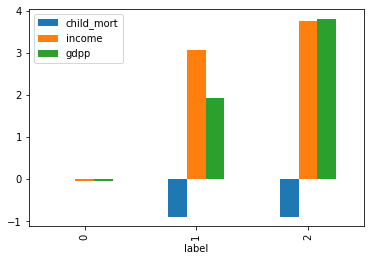

In [42]:
#scale df_kmean data since the columns are of different magnitudes. It makes our visualization easy
scaler = StandardScaler()
df_single_scaled = scaler.fit_transform(df_single[['child_mort','income','gdpp']])
df_single_scaled = pd.DataFrame(df_single_scaled,columns=['child_mort','income','gdpp'])
df_single_scaled = pd.concat([df_single_scaled,df_single['label']],axis=1)

df_single_scaled.groupby('label').mean().plot(kind = 'bar')

Observation: 
<pre>
As explained above, few countries that belong to cluster 0 have high child mortality rate, low income and low gdp.
</pre>

In [43]:
#find top 5 countries that need aid
df_single[df_single['label'] == 0].sort_values(by = ['gdpp','child_mort', 'income'], ascending = [True,False, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,0


Observation: 
<pre>
The results obtained from single linkage hierarchical clustering suggest that these 5 countries should be given priority in providing aid:
1.Burundi 
2.Liberia
3.Congo,Dem. Rep.
4.Niger 
5.Sierra Leone
</pre>

<h4>Complete Linkage</h4>

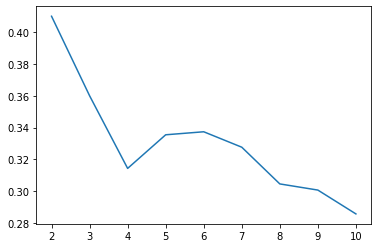

In [44]:
#perform hierarchical clustering with complete linkage and plot silhouette scores to find best k
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    complete = AgglomerativeClustering(n_clusters = k,linkage='complete').fit(df1)
    ss.append([k, silhouette_score(df1, complete.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

<pre>
best cluster: k = 5
</pre>

In [45]:
#build complete linkage model with optimal number of clusters
complete = AgglomerativeClustering(n_clusters = 5,linkage='complete')
complete.fit(df1)

AgglomerativeClustering(linkage='complete', n_clusters=5)

In [46]:
#make copy of data
df_complete = df.copy()

In [47]:
#convert labels to dataframe
label  = pd.DataFrame(complete.labels_, columns= ['label'])
label.head()

,label
0,1
1,4
2,4
3,1
4,0


In [48]:
#concatenate labels with df_Complete dataframe
df_complete = pd.concat([df_complete, label], axis =1)
df_complete.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,4
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,4
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [49]:
#See how many data points belong to each cluster
df_complete.label.value_counts()

4    76
0    41
1    30
3    12
2     8
Name: label, dtype: int64

[Text(0.5, 1.0, 'income vs child mortality')]

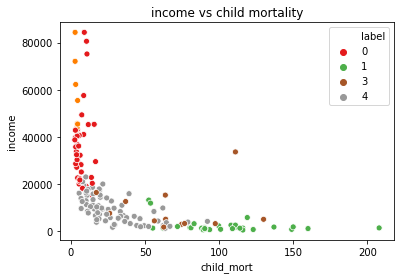

In [50]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'income', hue = 'label', data = df_complete, palette = 'Set1').set(title="income vs child mortality")

[Text(0.5, 1.0, 'gdpp vs child mortality')]

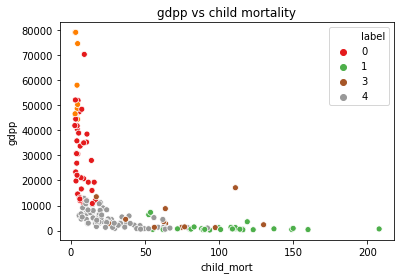

In [51]:
# Plot the cluster
sns.scatterplot(x = 'child_mort', y = 'gdpp', hue = 'label', data = df_complete, palette = 'Set1').set(title="gdpp vs child mortality")

[Text(0.5, 1.0, 'income vs gdpp')]

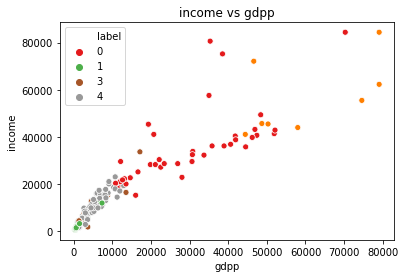

In [52]:
# Plot the cluster
sns.scatterplot(x = 'gdpp', y = 'income', hue = 'label', data = df_complete, palette = 'Set1').set(title="income vs gdpp")

Observation: 
<pre>
Countries that belong to cluster 1 need aid, as they have low income, low gdp and high child mortality rate compared to others
</pre>

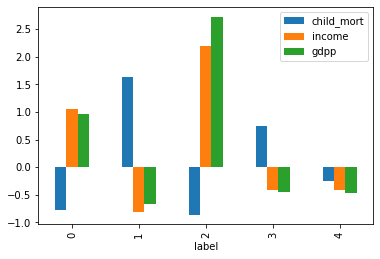

In [53]:
#scale df_kmean data since the columns are of different magnitudes. It makes our visualization easy
scaler = StandardScaler()
df_complete_scaled = scaler.fit_transform(df_complete[['child_mort','income','gdpp']])
df_complete_scaled = pd.DataFrame(df_complete_scaled,columns=['child_mort','income','gdpp'])
df_complete_scaled = pd.concat([df_complete_scaled,df_complete['label']],axis=1)

df_complete_scaled.groupby('label').mean().plot(kind = 'bar')

In [54]:
#find top 5 countries that need aid
df_complete[df_complete['label'] == 1].sort_values(by = ['gdpp','child_mort', 'income'], ascending = [True,False, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0,1
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0,1
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0,1
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0,1
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0,1


Observation: 
<pre>
The results obtained from complete linkage hierarchical clustering suggest that these 5 countries should be given priority in providing aid:
1.Burundi 
2.Liberia
3.Congo,Dem. Rep.
4.Niger 
5.Sierra Leone
</pre>

Conclusion:
<pre>
1.The results obtained from all the clustering methods are same. The countries that need aid are Burundi, Liberia, Congo, Dem. Rep., Niger 
and Sierra Leone.
2.Among Hierarchical clustering methods, complete linkage clustering performs well as it is performs well on noise data compared to single 
linkage clustering method.
3.In our analysis, we gave more preference to gdp, followed by child mortality and income to determine the top 5 countries that need aid.
</pre>


<h4>Choosing countries based on socio economic and health factors</h4>

In [55]:
df.sort_values(by = ['gdpp','child_mort', 'income'], ascending = [True,False, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.2600,231.0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.0200,327.0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.5400,334.0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,6.5636,348.0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.2000,399.0


Observation:
<pre>
We used the same socio economic and health factors that we used in our clustering analysis to find the top 5 countries that need aid and we obtained the same results as our clustering analysis results.
</pre>

<pre>
The results obtained from analysis using socio economic and health factors suggest that these 5 countries should be given priority in providing aid:
1.Burundi 
2.Liberia
3.Congo,Dem. Rep.
4.Niger 
5.Sierra Leone
</pre>
